In [1]:
from fastai.conv_learner import *
from fastai.dataset import *

import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import scipy.optimize as opt

/home/usst/anaconda3/envs/dxzpy/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
import random 
seed = 42
random.seed(seed)
np.random.seed(seed)

In [3]:
PATH = './'
TRAIN = './train/'
TEST = './test/'
LABELS = './TRAIN.csv'#'./HPAv18RBGY_wodpl.csv'

MOREDATA = './moredata/'
MORELABELS = './HPAv18RBGY_wodpl.csv'

SAMPLE = './sample_submission.csv'

In [4]:
name_label_dict = {
0:  'Nucleoplasm',
1:  'Nuclear membrane',
2:  'Nucleoli',   
3:  'Nucleoli fibrillar center',
4:  'Nuclear speckles',
5:  'Nuclear bodies',
6:  'Endoplasmic reticulum',   
7:  'Golgi apparatus',
8:  'Peroxisomes',
9:  'Endosomes',
10:  'Lysosomes',
11:  'Intermediate filaments',
12:  'Actin filaments',
13:  'Focal adhesion sites',   
14:  'Microtubules',
15:  'Microtubule ends',  
16:  'Cytokinetic bridge',   
17:  'Mitotic spindle',
18:  'Microtubule organizing center',  
19:  'Centrosome',
20:  'Lipid droplets',
21:  'Plasma membrane',   
22:  'Cell junctions', 
23:  'Mitochondria',
24:  'Aggresome',
25:  'Cytosol',
26:  'Cytoplasmic bodies',   
27:  'Rods & rings' }

In [5]:
moredata_names = list(pd.read_csv(MORELABELS)['Id'])
train_names = sorted({f[:36] for f in os.listdir(TRAIN)})
train_names += moredata_names

test_names = sorted({f[:36] for f in os.listdir(TEST)})
print('train:',len(train_names),'  test:',len(test_names))
tr_n,val_n = train_test_split(train_names, test_size=0.1, random_state=seed)
print('train:',len(tr_n),'  val:',len(val_n))

train: 105678   test: 11702
train: 95110   val: 10568


In [6]:
#creating duplicates for rare classes in train set
class Oversampling:
    def __init__(self,path):
        self.train_labels = pd.read_csv(path).set_index('Id')
        self.train_labels['Target'] = [[int(i) for i in s.split()] 
                                       for s in self.train_labels['Target']]  
        #set the minimum number of duplicates for each class
        self.multi = [1,1,1,1,1,1,1,1,
                      4,4,4,1,1,1,1,4,
                      2,2,1,1,2,1,1,1,
                      2,1,2,4]

    def get(self,image_id):
        labels = self.train_labels.loc[image_id,'Target'] if image_id \
          in self.train_labels.index else []
        m = 1
 
        for l in labels:
            if m < self.multi[l]: m = self.multi[l]
        return m
    
s = Oversampling(os.path.join(PATH,'train.csv'))
tr_n = [idx for idx in tr_n for _ in range(s.get(idx))]
print(len(tr_n),flush=True)

96770


In [7]:
def open_rgby(path,id): #a function that reads RGB image
    colors = ['red','green','blue']
    flags = cv2.IMREAD_GRAYSCALE
    try:
        img = [cv2.imread(os.path.join(path, id+'_'+color+'.png'), flags).astype(np.float32)/255
               for color in colors]
    except:
        img = [cv2.imread(os.path.join(MOREDATA, id+'_'+color+'.png'), flags).astype(np.float32)/255
               for color in colors]
    return np.stack(img, axis=-1)

"""

"""       

'\n\n'

In [8]:
class pdFilesDataset(FilesDataset):
    def __init__(self, fnames, path, transform):
        self.labels = pd.read_csv(LABELS).set_index('Id')
        self.labels['Target'] = [[int(i) for i in s.split()] for s in self.labels['Target']]
        super().__init__(fnames, transform, path)
    
    def get_x(self, i):
        img = open_rgby(self.path,self.fnames[i])
        if self.sz == 512: return img 
        else: return cv2.resize(img, (self.sz, self.sz),cv2.INTER_AREA)
    
    def get_y(self, i):
        if(self.path == TEST): return np.zeros(len(name_label_dict),dtype=np.int)
        else:
            labels = self.labels.loc[self.fnames[i]]['Target']
            return np.eye(len(name_label_dict),dtype=np.float)[labels].sum(axis=0)
        
    @property
    def is_multi(self): return True
    @property
    def is_reg(self):return True
    #this flag is set to remove the output sigmoid that allows log(sigmoid) optimization
    #of the numerical stability of the loss function
    
    def get_c(self): return len(name_label_dict) #number of classes

In [9]:
def get_data(sz,bs,is_test=False):
    #data augmentation
    if is_test:
        aug_tfms = [RandomRotate(30, tfm_y=TfmType.NO),
                RandomDihedral(tfm_y=TfmType.NO)]
    else:
        aug_tfms = [RandomRotate(30, tfm_y=TfmType.NO),
                RandomDihedral(tfm_y=TfmType.NO),
                RandomLighting(0.05, 0.05, tfm_y=TfmType.NO),
                Cutout(n_holes=25, length=10*sz//128, tfm_y=TfmType.NO)]
    #mean and std in of each channel in the train set
    #stats = A([0.08069, 0.05258, 0.05487], [0.13704, 0.10145, 0.15313])
    stats = A([0.05634, 0.05198, 0.03216],[0.0859 , 0.08025, 0.0859])
    tfms = tfms_from_stats(stats, sz, crop_type=CropType.NO, tfm_y=TfmType.NO, 
                aug_tfms=aug_tfms)
    ds = ImageData.get_ds(pdFilesDataset, (tr_n[:-(len(tr_n)%bs)],TRAIN), 
                (val_n,TRAIN), tfms, test=(test_names,TEST))
    md = ImageData(PATH, ds, bs, num_workers=nw, classes=None)
    return md

# HPAv18 all RGBY (each image is colored RGB png image 512x512)
#stats = A([0.06734, 0.05087, 0.03266, 0.09257],[0.11997, 0.10335, 0.10124, 0.1574 ])
#HPAv18+orginal
#([0.05634, 0.05198, 0.03216, 0.09692],[0.0859 , 0.08025, 0.0859 , 0.13703])
#([0.07265, 0.05087, 0.0456 , 0.08611],[0.12196, 0.09341, 0.13714, 0.13533])

In [10]:
nw = 2   #number of workers for data loader
arch = resnet34 #specify target architecture

bs = 32
sz = 256
md = get_data(sz,bs,is_test=True)

x,y = next(iter(md.trn_dl))
x.shape, y.shape

(torch.Size([32, 3, 256, 256]), torch.Size([32, 28]))

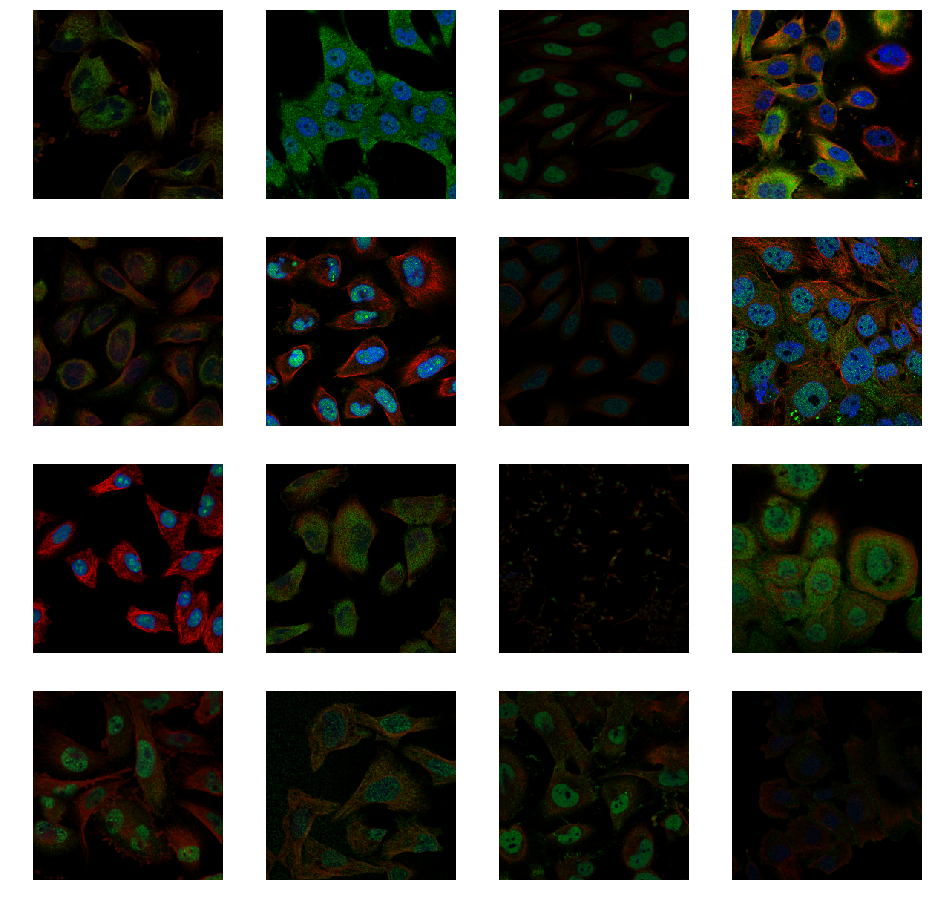

In [11]:
def display_imgs(x):
    columns = 4
    bs = x.shape[0]
    rows = min((bs+3)//4,4)
    fig=plt.figure(figsize=(columns*4, rows*4))
    for i in range(rows):
        for j in range(columns):
            idx = i+j*columns
            fig.add_subplot(rows, columns, idx+1)
            plt.axis('off')
            plt.imshow((x[idx,:,:,:3]*255).astype(np.int))
    plt.show()
    
display_imgs(np.asarray(md.trn_ds.denorm(x)))

In [12]:
def acc(preds,targs,th=0.0):
    preds = (preds > th).int()
    targs = targs.int()
    return (preds==targs).float().mean()

In [13]:
class F1:
    __name__ = 'F1 macro'
    def __init__(self,n=28):
        self.n = n
        self.TP = np.zeros(self.n)
        self.FP = np.zeros(self.n)
        self.FN = np.zeros(self.n)

    def __call__(self,preds,targs,th=0.0):
        preds = (preds > th).int()
        targs = targs.int()
        self.TP += (preds*targs).float().sum(dim=0)
        self.FP += (preds > targs).float().sum(dim=0)
        self.FN += (preds < targs).float().sum(dim=0)
        score = (2.0*self.TP/(2.0*self.TP + self.FP + self.FN + 1e-6)).mean()
        return score

    def reset(self):
        #macro F1 score
        score = (2.0*self.TP/(2.0*self.TP + self.FP + self.FN + 1e-6))
        print('F1 macro:',score.mean(),flush=True)
        #print('F1:',score)
        self.TP = np.zeros(self.n)
        self.FP = np.zeros(self.n)
        self.FN = np.zeros(self.n)

class F1_callback(Callback):
    def __init__(self, n=28):
        self.f1 = F1(n)

    def on_epoch_end(self, metrics):
        self.f1.reset()

In [14]:
sz = 512 #image size
bs = 64  #batch size

md = get_data(sz,bs)
learner = ConvLearner.pretrained(arch, md, ps=0.5) #dropout 50%
learner.models.model = torch.nn.DataParallel(learner.models.model,device_ids=[0, 1])
learner.opt_fn = optim.Adam
learner.clip = 1.0 #gradient clipping
learner.crit = nn.BCEWithLogitsLoss()
f1_callback = F1_callback()
learner.metrics = [acc,f1_callback.f1]
learner.summary

/home/usst/anaconda3/envs/dxzpy/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


<bound method ConvLearner.summary of DataParallel(
  (module): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [27]:
"""
learner.lr_find()
learner.sched.plot()
"""

'\nlearner.lr_find()\nlearner.sched.plot()\n'

In [19]:
lr = 0.5e-2
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    learner.fit(lr,1,callbacks=[f1_callback])

HBox(children=(IntProgress(value=0, description='Epoch', max=1, style=ProgressStyle(description_width='initial')), HTML(value='')))

F1 macro: 0.08120854180012242                                  
epoch      trn_loss   val_loss   acc        F1 macro   
    0      0.145089   0.139153   0.953475   0.079257  



In [15]:
lr = 0.5e-2
learner.unfreeze()
lrs=np.array([lr/10,lr/3,lr])

In [21]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    learner.fit(lrs/4,4,cycle_len=2,use_clr=(10,20),callbacks=[f1_callback])

HBox(children=(IntProgress(value=0, description='Epoch', max=8, style=ProgressStyle(description_width='initial')), HTML(value='')))

F1 macro: 0.3463989769254946                                   
epoch      trn_loss   val_loss   acc        F1 macro   
    0      0.107339   0.095632   0.967229   0.343969  
F1 macro: 0.4197532595519167                                    
    1      0.096243   0.087037   0.970518   0.417951  
F1 macro: 0.4027151200392437                                    
    2      0.096478   0.09171    0.96899    0.398692  
F1 macro: 0.4834481455010426                                    
    3      0.09259    0.084147   0.971035   0.481048  
F1 macro: 0.4817730104516443                                    
    4      0.092551   0.085519   0.970822   0.468757  
F1 macro: 0.5116524654274245                                    
    5      0.089036   0.081741   0.972251   0.500471  
F1 macro: 0.4993197979345919                                    
    6      0.092634   0.083332   0.971558   0.493588  
F1 macro: 0.5436750944695734                                    
    7      0.088244   0.080299   0.97244

In [16]:
learner.load('ResNet34_RGB_1')

In [17]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    learner.fit(lrs/16,2,cycle_len=4,use_clr=(10,20),callbacks=[f1_callback])

HBox(children=(IntProgress(value=0, description='Epoch', max=8, style=ProgressStyle(description_width='initial')), HTML(value='')))

F1 macro: 0.5657961426202853                                    
epoch      trn_loss   val_loss   acc        F1 macro   
    0      0.084321   0.079053   0.97287    0.549359  
F1 macro: 0.5652490676996824                                    
    1      0.084165   0.078567   0.972789   0.540836  
F1 macro: 0.5636305868654985                                    
    2      0.082562   0.078191   0.973093   0.543889  
F1 macro: 0.5708003963483175                                    
    3      0.079988   0.077505   0.973279   0.551216  
F1 macro: 0.5638268183969696                                    
    4      0.081101   0.077555   0.973268   0.546429  
F1 macro: 0.5728673117131161                                    
    5      0.081359   0.077873   0.973258   0.546979  
F1 macro: 0.573995893616193                                     
    6      0.079473   0.077058   0.973427   0.548934  
F1 macro: 0.585627882071973                                     
    7      0.080156   0.076554   0.9735

In [18]:
learner.save('ResNet34_RGB_2')

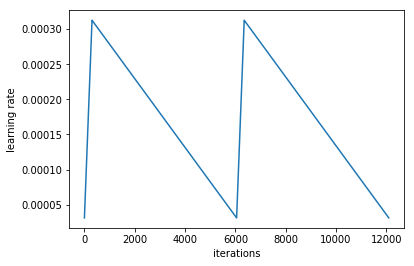

In [19]:
learner.sched.plot_lr()

In [20]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    learner.fit(lrs/32,1,cycle_len=8,use_clr=(10,20),callbacks=[f1_callback])

HBox(children=(IntProgress(value=0, description='Epoch', max=8, style=ProgressStyle(description_width='initial')), HTML(value='')))

F1 macro: 0.5840648705030389                                    
epoch      trn_loss   val_loss   acc        F1 macro   
    0      0.078482   0.077018   0.973272   0.557034  
F1 macro: 0.5805102535991945                                    
    1      0.078203   0.076908   0.973508   0.551978  
F1 macro: 0.5869614262110715                                    
    2      0.079823   0.076505   0.973596   0.559883  
F1 macro: 0.5963353142881503                                    
    3      0.076727   0.076269   0.973681   0.566343  
F1 macro: 0.5971274475024277                                    
    4      0.0801     0.076236   0.973606   0.56759   
F1 macro: 0.5907567284319176                                    
    5      0.076651   0.075784   0.973698   0.560073  
F1 macro: 0.5971118487035014                                    
    6      0.078846   0.075736   0.973782   0.568995  
F1 macro: 0.5938818856985454                                    
    7      0.075779   0.075855   0.9736

In [21]:
learner.save('ResNet34_RGB_3')

In [34]:
md = get_data(sz,bs,is_test=True)
learner.set_data(md)
preds,y = learner.TTA(n_aug=8)
preds = np.stack(preds, axis=-1)
pred = preds.mean(axis=-1)

In [23]:
def sigmoid_np(x):
    return 1.0/(1.0 + np.exp(-x))

def F1_soft(preds,targs,th=0.0,d=25.0):
    preds = sigmoid_np(d*(preds - th))
    targs = targs.astype(np.float)
    score = 2.0*(preds*targs).sum(axis=0)/((preds+targs).sum(axis=0) + 1e-6)
    return score

def fit_val(x,y):
    params = np.zeros(len(name_label_dict))
    wd = 1e-5
    error = lambda p: np.concatenate((F1_soft(x,y,p) - 1.0,
                                      wd*p), axis=None)
    p, success = opt.leastsq(error, params)
    return p

In [27]:
th = fit_val(pred,y)
print('Thresholds: ',th)
print('F1 macro: ',f1_score(y, pred>th, average='macro'))
print('F1 macro (th = 0.0): ',f1_score(y, pred>0.0, average='macro'))
print('F1 micro: ',f1_score(y, pred>th, average='micro'))

/home/usst/anaconda3/envs/dxzpy/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


Thresholds:  [-0.39229  0.623   -0.40999  0.12162 -0.25805  0.04402 -0.16872 -0.72424 -0.12588  0.39672  0.04446 -0.20357
 -0.17877 -0.14098  0.24456  0.      -0.28879  0.0195  -0.52393 -0.91333 -0.11795 -0.80662 -0.78883 -0.30186
  0.84247 -0.28906 -0.22502  0.     ]
F1 macro:  0.6810632594787672
F1 macro (th = 0.0):  0.6612330357754015
F1 micro:  0.7902981303688732


/home/usst/anaconda3/envs/dxzpy/lib/python3.6/site-packages/scipy/optimize/minpack.py:436: RuntimeWarning: Number of calls to function has reached maxfev = 5800.
  warnings.warn(errors[info][0], RuntimeWarning)
/home/usst/anaconda3/envs/dxzpy/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/usst/anaconda3/envs/dxzpy/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [28]:
from sklearn.model_selection import train_test_split
th, score, cv = 0,0,10
for i in range(cv):
    xt,xv,yt,yv = train_test_split(pred,y,test_size=0.5,random_state=i)
    th_i = fit_val(xt,yt)
    th += th_i
    score += f1_score(yv, xv>th_i, average='macro')
th/=cv
score/=cv
print('Thresholds: ',th)
print('F1 macro avr:',score)
print('F1 macro: ',f1_score(y, pred>th, average='macro'))
print('F1 micro: ',f1_score(y, pred>th, average='micro'))

/home/usst/anaconda3/envs/dxzpy/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/home/usst/anaconda3/envs/dxzpy/lib/python3.6/site-packages/scipy/optimize/minpack.py:436: RuntimeWarning: Number of calls to function has reached maxfev = 5800.
  warnings.warn(errors[info][0], RuntimeWarning)
/home/usst/anaconda3/envs/dxzpy/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/usst/anaconda3/envs/dxzpy/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Thresholds:  [-0.16582  0.21614 -0.28493  0.11842  0.14974  0.336   -0.23532 -0.37097 -0.17308  0.51944  0.03728 -0.00035
  0.2616  -0.02123 -0.09371  0.      -0.17719 -0.25712 -0.44178 -0.19348 -0.20631 -0.46662 -0.01612 -0.25402
  0.48873 -0.26882 -0.04314  0.     ]
F1 macro avr: 0.6595738056697167
F1 macro:  0.6749429078122304
F1 micro:  0.7865307383379674


In [29]:
print('Fractions: ',(pred > th).mean(axis=0))
print('Fractions (true): ',(y > 0.5).mean(axis=0))

Fractions:  [0.45335 0.03636 0.10779 0.0399  0.04505 0.05888 0.02381 0.08945 0.00097 0.00161 0.00097 0.02477 0.01609
 0.0103  0.03089 0.      0.0119  0.00611 0.0222  0.03604 0.00386 0.11197 0.01802 0.08719 0.00547 0.26448
 0.00804 0.     ]
Fractions (true):  [0.4231  0.03829 0.1184  0.04665 0.05631 0.07754 0.03378 0.09878 0.00193 0.00161 0.00097 0.03185 0.01931
 0.01609 0.03346 0.00064 0.01737 0.00676 0.02767 0.0444  0.00579 0.11937 0.02445 0.09749 0.00644 0.25257
 0.00804 0.     ]


/home/usst/anaconda3/envs/dxzpy/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/usst/anaconda3/envs/dxzpy/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Nucleoplasm 0 0.8663729809104259 -0.16582330888675642


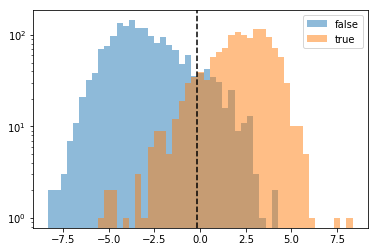

Nuclear membrane 1 0.8793103448275862 0.21614000101135064


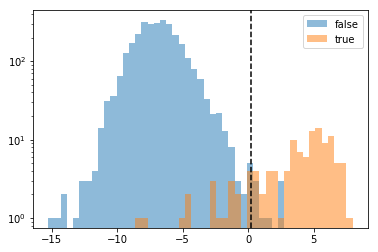

Nucleoli 2 0.8335704125177811 -0.2849339548098909


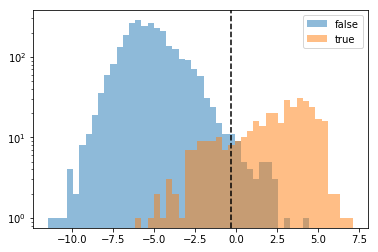

Nucleoli fibrillar center 3 0.7806691449814126 0.11841698582684337


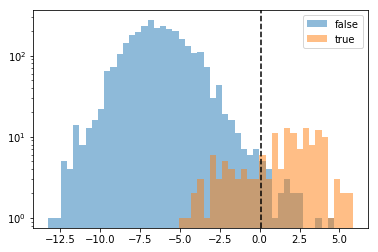

Nuclear speckles 4 0.7936507936507937 0.14974425104934944


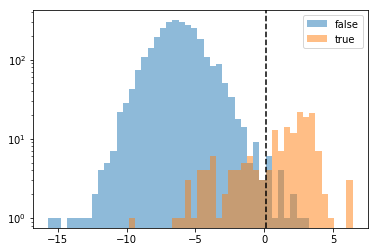

Nuclear bodies 5 0.7264150943396227 0.3360008653849604


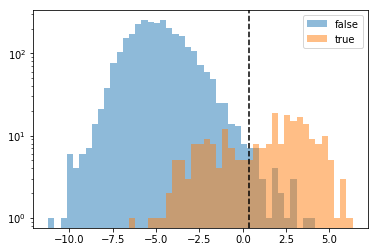

Endoplasmic reticulum 6 0.6033519553072625 -0.2353237533914902


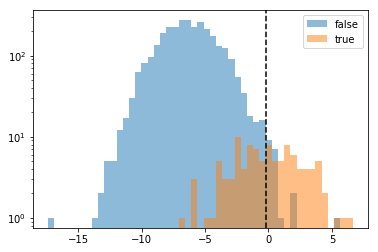

Golgi apparatus 7 0.841025641025641 -0.37097347473222175


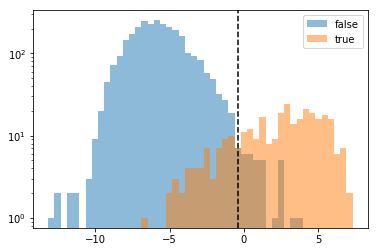

Peroxisomes 8 0.4444444444444444 -0.17308227059369344


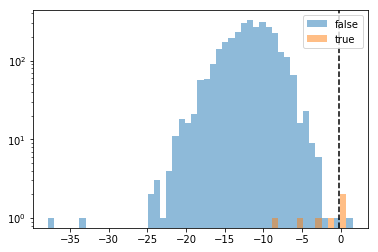

Endosomes 9 0.8000000000000002 0.5194393893354133


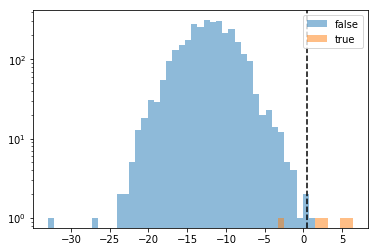

Lysosomes 10 1.0 0.03727702699952146


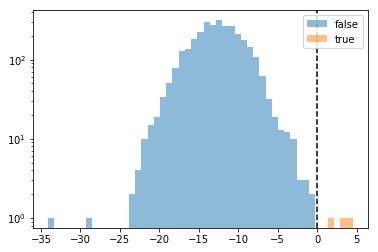

Intermediate filaments 11 0.7727272727272728 -0.0003488010574561384


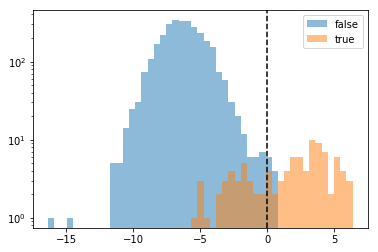

Actin filaments 12 0.7818181818181817 0.26160306212995676


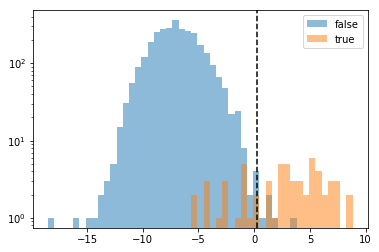

Focal adhesion sites 13 0.7317073170731707 -0.021225533421022173


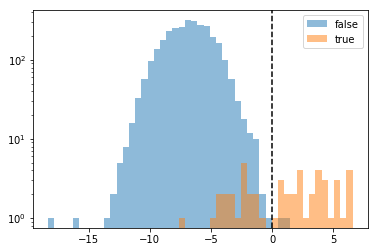

Microtubules 14 0.8899999999999999 -0.0937089018626978


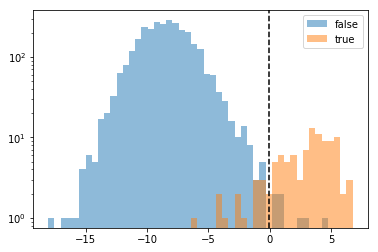

Microtubule ends 15 0.0 0.0


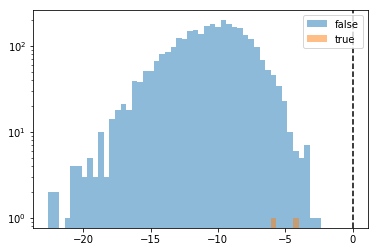

Cytokinetic bridge 16 0.5494505494505494 -0.17719153779020283


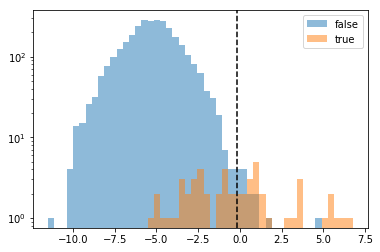

Mitotic spindle 17 0.5 -0.2571157528263939


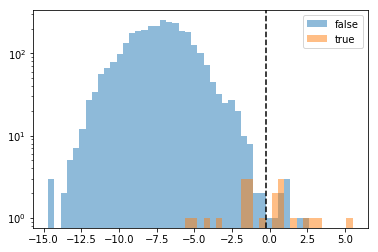

Microtubule organizing center 18 0.6580645161290324 -0.4417759272990799


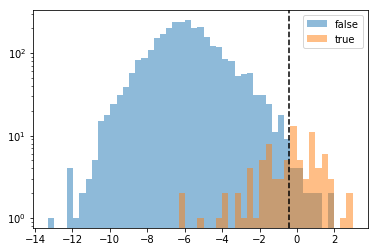

Centrosome 19 0.648 -0.19348304573600913


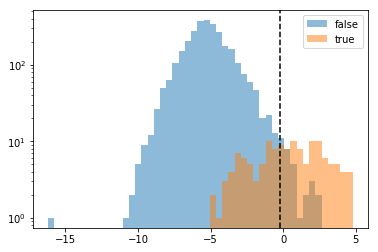

Lipid droplets 20 0.6666666666666667 -0.2063052529314961


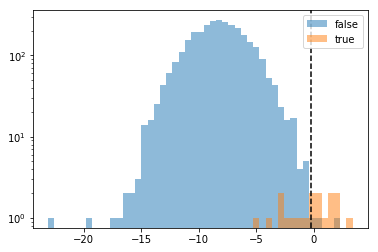

Plasma membrane 21 0.7315716272600835 -0.4666244915958376


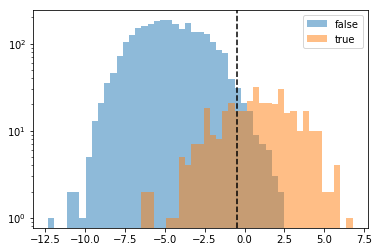

Cell junctions 22 0.6818181818181818 -0.0161152055231001


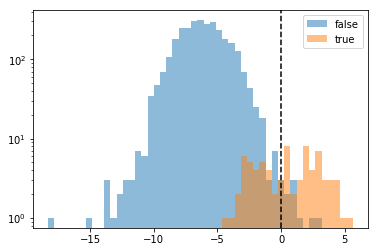

Mitochondria 23 0.8397212543554007 -0.254022268385165


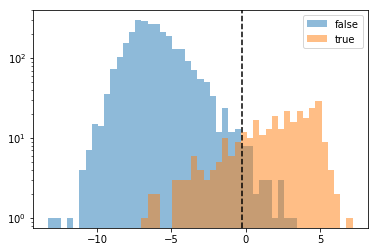

Aggresome 24 0.6486486486486486 0.4887259661378793


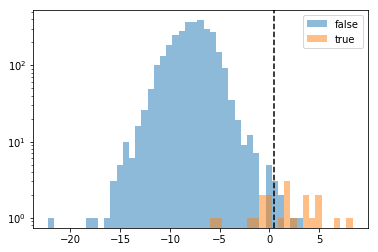

Cytosol 25 0.7093963907902925 -0.2688190672836249


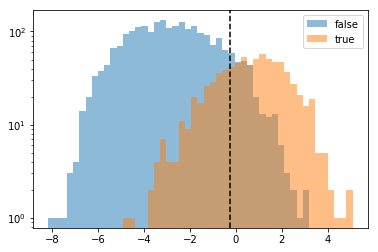

Cytoplasmic bodies 26 0.52 -0.043136452346458465


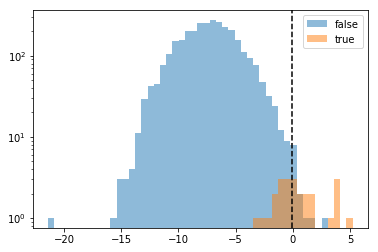

Rods & rings 27 0.0 0.0


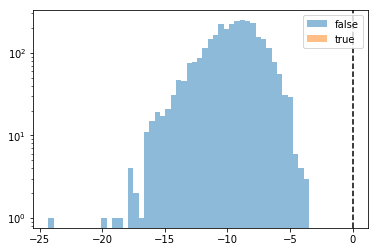

In [30]:
f1 = f1_score(y, pred>th, average=None)
for i in range(len(name_label_dict)):
    bins = np.linspace(pred[:,i].min(), pred[:,i].max(), 50)
    plt.hist(pred[y[:,i] == 0][:,i], bins, alpha=0.5, log=True, label='false')
    plt.hist(pred[y[:,i] == 1][:,i], bins, alpha=0.5, log=True, label='true')
    plt.legend(loc='upper right')
    print(name_label_dict[i],i, f1[i], th[i])
    plt.axvline(x=th[i], color='k', linestyle='--')
    plt.show()

In [ ]:
preds_t,y_t = learner.TTA(n_aug=8,is_test=True)
preds_t = np.stack(preds_t, axis=-1)
pred_t = preds_t.mean(axis=-1)

 12%|█▎        | 1/8 [01:59<13:58, 119.85s/it]

In [24]:
def save_pred(pred, th=0.0, fname='protein_classification.csv'):
    pred_list = []
    for line in pred:
        s = ' '.join(list([str(i) for i in np.nonzero(line>th)[0]]))
        pred_list.append(s)
    
    df = pd.DataFrame({'Id':learner.data.test_ds.fnames,'Predicted':pred_list})
    df.sort_values(by='Id').to_csv(fname, header=True, index=False)

In [33]:
save_pred(pred_t,th,'protein_classification_v.csv')
save_pred(pred_t,0.0,'protein_classification_0.csv')

In [28]:
lb_prob = [
 0.362397820,0.043841336,0.075268817,0.059322034,0.075268817,
 0.075268817,0.043841336,0.075268817,0.010000000,0.010000000,
 0.010000000,0.043841336,0.043841336,0.014198783,0.043841336,
 0.010000000,0.028806584,0.014198783,0.028806584,0.059322034,
 0.010000000,0.126126126,0.028806584,0.075268817,0.010000000,
 0.222493880,0.028806584,0.010000000]
# I replaced 0 by 0.01 since there may be a rounding error leading to 0

In [25]:
def Count_soft(preds,th=0.5,d=50.0):
    preds = sigmoid_np(d*(preds - th))
    return preds.mean(axis=0)

def fit_test(x,y):
    params = 0.5*np.ones(len(name_label_dict))
    wd = 1e-5
    error = lambda p: np.concatenate((Count_soft(x,p) - y,
                                      wd*(p - 0.5)), axis=None)
    p, success = opt.leastsq(error, params)
    return p

In [33]:
th_t = fit_test(pred_t,lb_prob)
print('Thresholds: ',th_t)
print('Fractions: ',(pred_t > th_t).mean(axis=0))
print('Fractions (th = 0.0): ',(pred_t > 0.0).mean(axis=0))

/home/usst/anaconda3/envs/dxzpy/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


Thresholds:  [ 0.41298 -1.96756 -0.08162 -2.2651  -2.82104 -1.33662 -2.18045 -1.01322 -4.96935 -4.46808 -5.61816 -1.81173
 -2.85922 -1.52002 -0.73532 -3.92857 -0.91133 -0.00339 -0.80464 -1.69917 -1.97249 -0.31762 -1.85885 -0.64752
 -1.0467   0.15589 -1.64391  0.5    ]
Fractions:  [0.36207 0.04384 0.07546 0.05965 0.07546 0.0752  0.04367 0.07503 0.01    0.01    0.01    0.04375 0.0441
 0.01419 0.04384 0.01    0.02897 0.01419 0.02888 0.05939 0.01008 0.12596 0.0288  0.07529 0.01    0.22236
 0.02888 0.     ]
Fractions (th = 0.0):  [0.3978  0.03111 0.07366 0.02974 0.03145 0.04427 0.01145 0.05401 0.0006  0.0006  0.00034 0.02478 0.01487
 0.00914 0.03811 0.00009 0.01504 0.01419 0.01615 0.02461 0.00282 0.10494 0.01222 0.06119 0.00795 0.245
 0.01094 0.     ]


In [34]:
save_pred(pred_t,th_t,'protein_classification_f.csv')

In [35]:
class_list = [8,9,10,15,20,24,27]
for i in class_list:
    th_t[i] = th[i]
save_pred(pred_t,th_t,'protein_classification_c.csv')

NameError: name 'th' is not defined

In [26]:
labels = pd.read_csv('train.csv').set_index('Id')
label_count = np.zeros(len(name_label_dict))
for label in labels['Target']:
    l = [int(i) for i in label.split()]
    label_count += np.eye(len(name_label_dict))[l].sum(axis=0)
label_fraction = label_count.astype(np.float)/len(labels)
label_count, label_fraction

(array([12885.,  1254.,  3621.,  1561.,  1858.,  2513.,  1008.,  2822.,    53.,    45.,    28.,  1093.,
          688.,   537.,  1066.,    21.,   530.,   210.,   902.,  1482.,   172.,  3777.,   802.,  2965.,
          322.,  8228.,   328.,    11.]),
 array([0.41468, 0.04036, 0.11654, 0.05024, 0.0598 , 0.08088, 0.03244, 0.09082, 0.00171, 0.00145, 0.0009 ,
        0.03518, 0.02214, 0.01728, 0.03431, 0.00068, 0.01706, 0.00676, 0.02903, 0.0477 , 0.00554, 0.12156,
        0.02581, 0.09542, 0.01036, 0.2648 , 0.01056, 0.00035]))

In [38]:
pre_1 = np.load('./KF_2/KF_1.npy')
pred_t = sigmoid_np(pred_t)-sigmoid_np(pre_1)

In [36]:
th_t = fit_test(pred_t,label_fraction)
print('Thresholds: ',th_t)
print('Fractions: ',(pred_t > th_t).mean(axis=0))
save_pred(pred_t,th_t,'protein_classification_t.csv')

Thresholds:  [0.96035 0.47092 0.42561 0.28505 0.21482 0.34321 0.31627 0.41446 0.25675 0.45872 0.41329 0.61984 0.57375
 0.32708 1.16107 0.5628  0.69347 1.16496 0.529   0.49084 0.46563 0.88507 0.37759 0.42347 0.56856 0.89778
 0.68702 0.20561]
Fractions:  [0.41497 0.04033 0.11588 0.04974 0.05862 0.08058 0.03213 0.09067 0.00162 0.00145 0.00094 0.03495 0.02196
 0.01709 0.03435 0.00068 0.01709 0.00675 0.02888 0.04768 0.00547 0.1216  0.02589 0.09511 0.01043 0.26534
 0.01068 0.00026]


In [33]:
for i in pred_t:
    if(i[-1])>0:
        print(i[-1])